In [1]:
from IPython.display import display, Image
from pprint import pprint
from itertools import chain

from ginv import *
sympy.init_printing()

Условие на классические симметрии
\begin{equation}
\begin{aligned}
\mathbf{u_{tx}}& + \alpha u_{xx} + \beta u_{xx} u_{x} + \gamma u_{yy} = 0 \\
\mathbf{u_{\varepsilon }}& - F(t, x, y, u, u_{t}, u_{x}, u_{y}) = 0 \\
\end{aligned}
\end{equation}
Для второго уравнения системы введем полные производные от $F$.
\begin{equation}
\begin{aligned}
\frac{dF}{dt} &= F_t  + F_u u_{t} + F_{u_{t}} u_{tt} + F_{u_{x}} u_{tx} + F_{u_{y}} u_{ty}\\
\frac{dF}{dx} &= F_x  + F_u u_{x} + F_{u_{t}} u_{tx} + F_{u_{x}} u_{xx} + F_{u_{y}} u_{xy}\\
\frac{dF}{dy} &= F_y  + F_u u_{y} + F_{u_{t}} u_{ty} + F_{u_{x}} u_{xy} + F_{u_{y}} u_{yy}\\
\end{aligned}
\end{equation}

Условие интегрируемости (совместности) данной системы можно записать через $S$-полином (лексикографическое упорядочение $t \succ x \succ y$)
\begin{equation}
\big(\mathbf{u_{tx}} + \alpha u_{xx} + \beta u_{xx} u_{x} + \gamma u_{yy})_\varepsilon 
- {\mathbf{u_{\varepsilon }}}_{tx} + \frac{d^2}{dtdx}F = 0
\end{equation}

В последнем уравнении в силу правила дифференцирования Лейбница производная по $\varepsilon $
входит в условие интрегриемости линейно. 
\begin{equation}
\alpha u_{\varepsilon xx} + \beta u_{xx} u_{\varepsilon x}  + \beta u_{\varepsilon xx} u_{x} + \gamma u_{\varepsilon yy} + \frac{d^2}{dtdx}F = 0
\end{equation}
При этом мы можем заменить $u_{\varepsilon }$ на $F$ используя полные производные от $F$.
\begin{equation}
\frac{d^2}{dx^2}F + \beta u_{xx}\frac{d}{dx}F
 + \beta \frac{d^2}{dx^2}F u_{x} + \gamma\frac{d^2}{dy^2}F 
+ \frac{d^2}{dtdx}F = 0
\end{equation}

Учитывая в силу самого уравнения Линя-Рейснера-Цзяня
\begin{equation}
\begin{aligned}
u_{tx} &= - \alpha u_{xx} - \beta u_{xx} u_{x} - \gamma u_{yy} \\
u_{ttx} &= - \alpha u_{txx} -  \beta u_{txx} u_{x} -  \beta u_{xx} (- \alpha u_{xx} - \beta u_{xx} u_{x} - \gamma u_{yy}) - \gamma u_{tyy}  \\
u_{txx} &= - \alpha u_{xxx} -  \beta u_{xxx} u_{x} -  \beta u_{xxx} u_{xx} - \gamma u_{xyy}  \\
u_{txy} &= - \alpha u_{xxy}  -  \beta u_{xxy} u_{x} -  \beta u_{xxx} u_{xy} - \gamma u_{yyy}  \\
& \cdots \\
\end{aligned}
\end{equation}
и то что само $F$ не зависит от производных выше первого порядка $u_{t}, u_{x}, u_{y}$ можно получить 
систему линейных уравнений на $F$.

In [2]:
a, b, g = sympy.symbols('alpha, beta, gamma', real=True)
eps, t, x, y = sympy.symbols('ε, t, x, y', real=True)
U = sympy.Function('U')(eps, t, x, y)

u, ut, ux, uy = sympy.symbols('u, u_t, u_x, u_y', real=True)
F = sympy.Function('F')(t, x, y, u, ut, ux, uy)

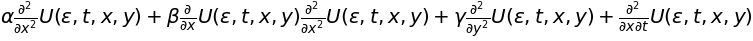

In [3]:
eq1 = U.diff(t, x) + a*U.diff(x, 2) + b*U.diff(x)*U.diff(x, 2) + g*U.diff(y, 2)
eq1

In [4]:
dct = {U: "u", F: "F"}
def compact(f):
    def cmpct(a):
        if not a.args:
            return a
        else:
            if a in dct:
                return sympy.Symbol(dct[a], real=True)
            elif a.func == sympy.Derivative:
                m = []
                for xi in a.args[1:]:
                    if isinstance(xi, sympy.Symbol):
                        m.append(str(xi))
                    else:
                        m.append(str(xi[0])*xi[1])
                return sympy.Symbol(f"{dct[a.args[0]]}_{{{''.join(m)}}}", real=True)
            else:
                return a.func(*tuple(cmpct(s) for s in a.args))
    return cmpct(f)

In [5]:
compact(eq1)

In [6]:
compact(eq1.diff(eps))

In [7]:
def Dt(a):
    return a.diff(t) + a.diff(u)*ut + a.diff(ut)*U.diff(t, t)\
         + a.diff(ux)*U.diff(x, t) + a.diff(uy)*U.diff(y, t)
def Dx(a):
    return a.diff(x) + a.diff(u)*ux + a.diff(ut)*U.diff(t, x)\
         + a.diff(ux)*U.diff(x, x) + a.diff(uy)*U.diff(y, x)
def Dy(a):
    return a.diff(y) + a.diff(u)*uy + a.diff(ut)*U.diff(t, y)\
         + a.diff(ux)*U.diff(x, y) + a.diff(uy)*U.diff(y, y)

In [8]:
toD = {
    t: Dt,\
    x: Dx,\
    y: Dy,\
}
def totalD(a):
    if not a.args:
        return a
    else:
        if a.func != sympy.Derivative:
            return a.func(*(totalD(s) for s in a.args))
        elif (eps, 1) not in a.args:
            return a
        else:
            assert a.args[0] == U
            r = F
            for v, l in a.args[1:]:
                if v != eps:
                    for i in range(l):
                        r = toD[v](r)
            return r
eq2 = totalD(eq1.diff(eps)).expand()     

In [9]:
compact(eq2)

In [10]:
s = sympy.solve(eq1, U.diff(t, x))[0]
def sub_eq(a):
    def find(args):
        r = 0
        for v, l in a.args[1:]:
            if v in (t, x):
                r += 1
        return r == 2
    if not a.args:
        return a
    else:
        if a.func != sympy.Derivative:
            return a.func(*(sub_eq(s) for s in a.args))
        elif a.args[0] != U or not find(a.args):
            return a
        else:
            r = s
            for v, l in a.args[1:]:
                if v in (t, x):
                    l -= 1
                r = r.diff(v, l)
            return r
eq3 = sub_eq(eq2).expand()
eq3 = sub_eq(eq3).expand()

In [11]:
compact(eq3)

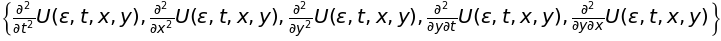

In [12]:
toU = {
    U.diff(t): ut,\
    U.diff(x): ux,\
    U.diff(y): uy,\
}
DF = set()
def lstD(a):
    if not a.args:
        return a
    else:
        if a.func != sympy.Derivative:
            return a.func(*(lstD(s) for s in a.args))
        elif a.args[0] != U:
            return a
        elif a in toU:
            return toU[a]
        else:
            DF.add(a)
            return a
eq4 = lstD(eq3).expand()
DF

In [13]:
for df in DF:
    deg = eq4.as_poly(df).degree()
    print(deg, df)

2 Derivative(U(ε, t, x, y), (y, 2))
2 Derivative(U(ε, t, x, y), x, y)
2 Derivative(U(ε, t, x, y), (x, 2))
2 Derivative(U(ε, t, x, y), t, y)
1 Derivative(U(ε, t, x, y), (t, 2))


In [24]:
eqs = [eq4]
for df in DF:
    r = []
    for eq in eqs:
        for d in range(3):
            if eq.coeff(df, d):
                r.append(eq.coeff(df, d))
    eqs = r
for eq in eqs:
    print(sympy.latex(compact(eq)) + r" = 0, \\")
[compact(eq) for eq in eqs]

F_{tu} u_{x} + F_{tx} + F_{uu} \alpha u_{x}^{2} + F_{uu} \beta u_{x}^{3} + F_{uu} \gamma u_{y}^{2} + F_{uu} u_{t} u_{x} + 2 F_{ux} \alpha u_{x} + 2 F_{ux} \beta u_{x}^{2} + F_{ux} u_{t} + 2 F_{uy} \gamma u_{y} + F_{xx} \alpha + F_{xx} \beta u_{x} + F_{yy} \gamma = 0, \\
F_{u_tx} + F_{uu_t} u_{x} = 0, \\
2 F_{u_ty} \gamma + F_{u_yx} + 2 F_{uu_t} \gamma u_{y} + F_{uu_y} u_{x} = 0, \\
F_{u_tu_t} \gamma = 0, \\
- F_{tu_t} \alpha - F_{tu_t} \beta u_{x} + F_{tu_x} - 2 F_{u_tx} \alpha^{2} - 4 F_{u_tx} \alpha \beta u_{x} - 2 F_{u_tx} \beta^{2} u_{x}^{2} + F_{u_xx} \alpha + F_{u_xx} \beta u_{x} - 2 F_{uu_t} \alpha^{2} u_{x} - 4 F_{uu_t} \alpha \beta u_{x}^{2} - F_{uu_t} \alpha u_{t} - 2 F_{uu_t} \beta^{2} u_{x}^{3} - F_{uu_t} \beta u_{t} u_{x} + F_{uu_x} \alpha u_{x} + F_{uu_x} \beta u_{x}^{2} + F_{uu_x} u_{t} + F_{u} \beta u_{x} + F_{x} \beta = 0, \\
- F_{u_tu_t} \alpha - F_{u_tu_t} \beta u_{x} + F_{u_tu_x} = 0, \\
- F_{u_tu_y} \alpha - F_{u_tu_y} \beta u_{x} + F_{u_xu_y} = 0, \\
F_{u_tu_t} \a

In [15]:
Monom.cmp = Monom.TOPdeglex

In [16]:
var = ['t', 'x', 'y', 'u', 'u_t', 'u_x', 'u_y']
fun = ['F']
Monom.init(var, fun)
df = PolyDiff.df
diff2poly = PolyDiff.diff2poly
var, fun = PolyDiff.init()
t, x, y, u, ut, ux, uy = var
F = fun[0]

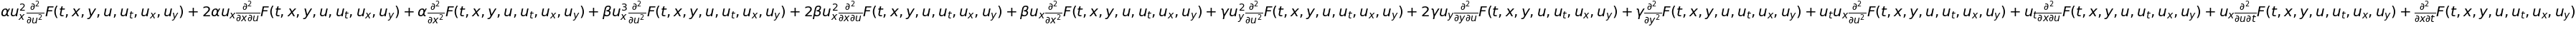

In [17]:
eqs[0]

In [18]:
diff2poly(eqs[0])

[[[0;1 1 0 0 0 0 0], 1],
 [[0;0 2 0 0 0 0 0], alpha + beta*u_x],
 [[0;0 0 2 0 0 0 0], gamma],
 [[0;1 0 0 1 0 0 0], u_x],
 [[0;0 1 0 1 0 0 0], 2*alpha*u_x + 2*beta*u_x**2 + u_t],
 [[0;0 0 1 1 0 0 0], 2*gamma*u_y],
 [[0;0 0 0 2 0 0 0], alpha*u_x**2 + beta*u_x**3 + gamma*u_y**2 + u_t*u_x]]

In [19]:
print(diff2poly(eqs[0]))

df(F, t, x) + df(F, x, 2)*(alpha + beta*u_x) + df(F, y, 2)*gamma + df(F, t, u)*u_x + df(F, x, u)*(2*alpha*u_x + 2*beta*u_x**2 + u_t) + df(F, y, u)*2*gamma*u_y + df(F, u, 2)*(alpha*u_x**2 + beta*u_x**3 + gamma*u_y**2 + u_t*u_x)


In [20]:
LRT = Janet()
res = ginvBlockLow([diff2poly(eq) for eq in eqs], \
LRT, level=1)
print(f"    crit1: {res[1]}")
print(f"    crit2: {res[2]}")
print(f"     time: {res[0]:.2f} sec")
print(f"    count: {LRT.count()}")
print(f"reduction: {LRT.reduction()}")
print(f"       HP: {LRT.HP()}")
LRT.saveImage('LRT.pdf', level=1)

prolong 0, Q 2
df(F, u_t, u_y)
prolong 0, Q 2
df(F, u_x, u_y), df(F, u_x, 2), df(F, u_t, u_x), df(F, y, u_x), df(F, u_t, 2), df(F, u_y, 2), df(F, y, u_t), df(F, x, u_t), df(F, t, u_t), df(F, t, u_x), df(F, t, x)
prolong 2, Q 0
df(F, y, u_y, 2)
prolong 3, Q 3
df(F, x, u_y, 2)
prolong 3, Q 3
df(F, t, u_y, 2)
prolong 3, Q 3
df(F, u, u_x)
prolong 2, Q 3
df(F, u, u_y, 2)
prolong 3, Q 3
df(F, x, u_x, u_y)
prolong 3, Q 3
df(F, x, u_y)
prolong 2, Q 3
df(F, u, u_y)
prolong 2, Q 3
df(F, u, u_t)
prolong 2, Q 3
df(F, y, u, u_y)
prolong 2, Q 3
df(F, t, u, u_y)
prolong 2, Q 3
df(F, x, u_x), df(F, x, u), df(F, y, u)
prolong 2, Q 3
df(F, u, 2)
prolong 2, Q 3
df(F, y, 2, u_y)
prolong 2, Q 3
df(F, t, y, u_y)
prolong 2, Q 3
df(F, t, 2, u_y)
prolong 2, Q 3
df(F, t, u, u_x)
prolong 3, Q 3
df(F, y, 2, u_x)
prolong 3, Q 3
df(F, t, y, u_x)
prolong 3, Q 3
df(F, x, 2)
prolong 2, Q 3
df(F, t, 2, u_x)
prolong 3, Q 3
df(F, t, u, u_t)
prolong 3, Q 3
df(F, y, 2, u_t)
prolong 3, Q 3
df(F, t, y, u_t)
prolong 3, Q 3
df

In [21]:
for w in LRT:
    print(w.poly)

df(F, u_y, 2)
df(F, u_x, u_y)
df(F, u_x, 2)
df(F, u_t, u_y)
df(F, u_t, u_x)
df(F, u_t, 2)
df(F, u, u_y)
df(F, u, u_x)
df(F, u, u_t)
df(F, u, 2)
df(F, y, u_y, 2)
df(F, y, u_x)*(-2*gamma) + df(F, t, u_y)*(-1)
df(F, y, u_t)
df(F, y, u)
df(F, y, 2, u_y)
df(F, y, 2, u_x)*(-gamma) + df(F, t, u)*(-1)
df(F, y, 2, u_t)
df(F, y, 2, u)
df(F, y, 3, u_y)
df(F, y, 3, u_x)
df(F, y, 3, u_t)
df(F, y, 3, u)
df(F, y, 4)*(-beta*gamma**2) + df(F, t, 3, u)*(-1)
df(F, x, u_y)
df(F, x, u_x)*(-3) + df(F, y, u_y)*2 + df(F, u)*(-1)
df(F, x, u_t)
df(F, x, u)
df(F, x, y, u_y)
df(F, x, y, u_x)
df(F, x, y, u_t)
df(F, x, y, u)
df(F, x, y, 2)*beta*gamma + df(F, t, 2, u)*(-1)
df(F, x, 2)*(-beta) + df(F, t, u)*(-1)
df(F, t, u_y, 2)
df(F, t, u_x)*(-3) + df(F, y, u_y)*(2*alpha + 2*beta*u_x) + df(F, x)*(-3*beta) + df(F, u)*(2*alpha - beta*u_x)
df(F, t, u_t)*3 + df(F, y, u_y)*(-4) + df(F, u)*(-1)
df(F, t, u, u_y)
df(F, t, u, u_x)
df(F, t, u, u_t)
df(F, t, u, 2)
df(F, t, y, u_y) + df(F, t, u)*(-2)
df(F, t, y, u_x)*(-1) + df(

In [22]:
for w in LRT.GB():
    print(w.poly)

df(F, u_y, 2)
df(F, u_x, u_y)
df(F, u_x, 2)
df(F, u_t, u_y)
df(F, u_t, u_x)
df(F, u_t, 2)
df(F, u, u_y)
df(F, u, u_x)
df(F, u, u_t)
df(F, u, 2)
df(F, y, u_x)*(-2*gamma) + df(F, t, u_y)*(-1)
df(F, y, u_t)
df(F, y, u)
df(F, y, 2, u_y)
df(F, y, 4)*(-beta*gamma**2) + df(F, t, 3, u)*(-1)
df(F, x, u_y)
df(F, x, u_x)*(-3) + df(F, y, u_y)*2 + df(F, u)*(-1)
df(F, x, u_t)
df(F, x, u)
df(F, x, y, 2)*beta*gamma + df(F, t, 2, u)*(-1)
df(F, x, 2)*(-beta) + df(F, t, u)*(-1)
df(F, t, u_x)*(-3) + df(F, y, u_y)*(2*alpha + 2*beta*u_x) + df(F, x)*(-3*beta) + df(F, u)*(2*alpha - beta*u_x)
df(F, t, u_t)*3 + df(F, y, u_y)*(-4) + df(F, u)*(-1)
df(F, t, u, u_t)
df(F, t, y, u_y) + df(F, t, u)*(-2)
df(F, t, x)*beta + df(F, y, 2)*beta*gamma + df(F, t, u)*(-alpha)
df(F, t, 2, u_y)*(-1) + df(F, x, y)*2*beta*gamma


In [23]:
for w in LRT.GB():
    print(sympy.latex(compact(sum(sympy.Function('F')(t, x, y, u, ut, ux, uy)\
    .diff(*((v, d) for v, d in zip(var, m)))*c for m, c in w.poly).expand())) + r" = 0, \\")

F_{u_yu_y} = 0, \\
F_{u_xu_y} = 0, \\
F_{u_xu_x} = 0, \\
F_{u_tu_y} = 0, \\
F_{u_tu_x} = 0, \\
F_{u_tu_t} = 0, \\
F_{uu_y} = 0, \\
F_{uu_x} = 0, \\
F_{uu_t} = 0, \\
F_{uu} = 0, \\
- F_{tu_y} - 2 F_{u_xy} \gamma = 0, \\
F_{u_ty} = 0, \\
F_{uy} = 0, \\
F_{u_yyy} = 0, \\
- F_{tttu} - F_{yyyy} \beta \gamma^{2} = 0, \\
F_{u_yx} = 0, \\
- 3 F_{u_xx} + 2 F_{u_yy} - F_{u} = 0, \\
F_{u_tx} = 0, \\
F_{ux} = 0, \\
- F_{ttu} + F_{xyy} \beta \gamma = 0, \\
- F_{tu} - F_{xx} \beta = 0, \\
- 3 F_{tu_x} + 2 F_{u_yy} \alpha + 2 F_{u_yy} \beta u_{x} + 2 F_{u} \alpha - F_{u} \beta u_{x} - 3 F_{x} \beta = 0, \\
3 F_{tu_t} - 4 F_{u_yy} - F_{u} = 0, \\
F_{tuu_t} = 0, \\
F_{tu_yy} - 2 F_{tu} = 0, \\
- F_{tu} \alpha + F_{tx} \beta + F_{yy} \beta \gamma = 0, \\
- F_{ttu_y} + 2 F_{xy} \beta \gamma = 0, \\


In [26]:
for w in LRT.GB():
    print(" + ".join([f"{m.df_latex()}{{{sympy.latex(c)}}}" for m, c in w.poly]) + r" = 0, \\")

{F}_{{u_y} {u_y}}{1} = 0, \\
{F}_{{u_x} {u_y}}{1} = 0, \\
{F}_{{u_x} {u_x}}{1} = 0, \\
{F}_{{u_t} {u_y}}{1} = 0, \\
{F}_{{u_t} {u_x}}{1} = 0, \\
{F}_{{u_t} {u_t}}{1} = 0, \\
{F}_{{u} {u_y}}{1} = 0, \\
{F}_{{u} {u_x}}{1} = 0, \\
{F}_{{u} {u_t}}{1} = 0, \\
{F}_{{u} {u}}{1} = 0, \\
{F}_{{y} {u_x}}{- 2 \gamma} + {F}_{{t} {u_y}}{-1} = 0, \\
{F}_{{y} {u_t}}{1} = 0, \\
{F}_{{y} {u}}{1} = 0, \\
{F}_{{y} {y} {u_y}}{1} = 0, \\
{F}_{{y} {y} {y} {y}}{- \beta \gamma^{2}} + {F}_{{t} {t} {t} {u}}{-1} = 0, \\
{F}_{{x} {u_y}}{1} = 0, \\
{F}_{{x} {u_x}}{-3} + {F}_{{y} {u_y}}{2} + {F}_{{u}}{-1} = 0, \\
{F}_{{x} {u_t}}{1} = 0, \\
{F}_{{x} {u}}{1} = 0, \\
{F}_{{x} {y} {y}}{\beta \gamma} + {F}_{{t} {t} {u}}{-1} = 0, \\
{F}_{{x} {x}}{- \beta} + {F}_{{t} {u}}{-1} = 0, \\
{F}_{{t} {u_x}}{-3} + {F}_{{y} {u_y}}{2 \alpha + 2 \beta u_{x}} + {F}_{{x}}{- 3 \beta} + {F}_{{u}}{2 \alpha - \beta u_{x}} = 0, \\
{F}_{{t} {u_t}}{3} + {F}_{{y} {u_y}}{-4} + {F}_{{u}}{-1} = 0, \\
{F}_{{t} {u} {u_t}}{1} = 0, \\
{F}_{{t} {y} {u

In [27]:
T = sum(sympy.Function(i)(t, x, y)*j for i, j in zip(\
    ('A', 'B', 'C', 'D', 'E'),
    (ut, ux, uy, u, 1)))
T

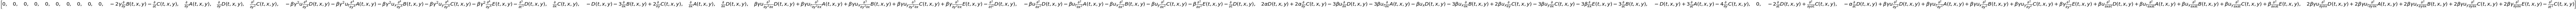

In [28]:
eqs1 = []
for w in LRT.GB():
    eqs1.append(sum(T.diff(*((v, d) for v, d in zip(var, m)))*c for m, c in w.poly).expand())
eqs1

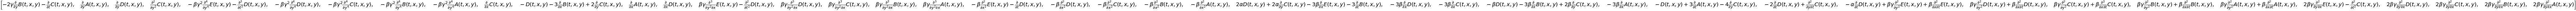

In [29]:
def to_eqs(a, var):
    for x in var:
        r = []
        for b in a:
            if b:
                r.append([b.coeff(x, i) for i in range(b.as_poly(x).degree()+1) if b.coeff(x, i)])
        a = chain(*r)
    return list(a)
eqs2 = to_eqs(eqs1, [ut, ux, uy, u])
eqs2

In [36]:
AAA = [sympy.Function(i)(t, x, y) for i in ('A', 'B', 'C', 'D', 'E')]
dct = {AAA[0]: "A", AAA[1]: "B", AAA[2]: "C", AAA[3]: "D",  AAA[4]: "E"}
for eq in eqs2:
    print(sympy.latex(compact(eq)) + r" = 0, \\")

- 2 B_{y} \gamma - C_{t} = 0, \\
A_{y} = 0, \\
D_{y} = 0, \\
C_{yy} = 0, \\
- D_{ttt} - E_{yyyy} \beta \gamma^{2} = 0, \\
- D_{yyyy} \beta \gamma^{2} = 0, \\
- C_{yyyy} \beta \gamma^{2} = 0, \\
- B_{yyyy} \beta \gamma^{2} = 0, \\
- A_{yyyy} \beta \gamma^{2} = 0, \\
C_{x} = 0, \\
- 3 B_{x} + 2 C_{y} - D = 0, \\
A_{x} = 0, \\
D_{x} = 0, \\
- D_{tt} + E_{xyy} \beta \gamma = 0, \\
D_{xyy} \beta \gamma = 0, \\
C_{xyy} \beta \gamma = 0, \\
B_{xyy} \beta \gamma = 0, \\
A_{xyy} \beta \gamma = 0, \\
- D_{t} - E_{xx} \beta = 0, \\
- D_{xx} \beta = 0, \\
- C_{xx} \beta = 0, \\
- B_{xx} \beta = 0, \\
- A_{xx} \beta = 0, \\
- 3 B_{t} + 2 C_{y} \alpha + 2 D \alpha - 3 E_{x} \beta = 0, \\
- 3 D_{x} \beta = 0, \\
- 3 C_{x} \beta = 0, \\
- 3 B_{x} \beta + 2 C_{y} \beta - D \beta = 0, \\
- 3 A_{x} \beta = 0, \\
3 A_{t} - 4 C_{y} - D = 0, \\
C_{ty} - 2 D_{t} = 0, \\
- D_{t} \alpha + E_{tx} \beta + E_{yy} \beta \gamma = 0, \\
D_{tx} \beta + D_{yy} \beta \gamma = 0, \\
C_{tx} \beta + C_{yy} \beta \gamma = 

In [37]:
var = ['t', 'x', 'y']
fun = ['A', 'B', 'C', 'D', 'E']
Monom.init(var, fun)
df = PolyDiff.df
diff2poly = PolyDiff.diff2poly
var, fun = PolyDiff.init()
t, x, y = var
A, B, C, D, E = fun

LRT1 = Forest(Janet)
res = ginvBlockLow([diff2poly(eq) for eq in eqs1 if eq], \
LRT1, level=1)
print(f"    crit1: {res[1]}")
print(f"    crit2: {res[2]}")
print(f"     time: {res[0]:.2f} sec")
print(f"    count: {LRT1.count()}")
print(f"reduction: {LRT1.reduction()}")
print(f"       HP: {LRT1.HP()}")

prolong 0, Q 1
df(A, y)
prolong 0, Q 1
df(D, y)
prolong 0, Q 1
df(A, x)
prolong 0, Q 1
df(B, x)
prolong 0, Q 1
df(C, x)
prolong 0, Q 1
df(D, x)
prolong 0, Q 1
df(A, t)
prolong 0, Q 1
df(B, t)
prolong 0, Q 1
df(C, t)
prolong 0, Q 2
df(C, y, 2)
prolong 0, Q 2
df(B, y, 2), df(E, x, 2), df(E, t, x)
prolong 1, Q 3
df(E, x, y, 2)
prolong 2, Q 4
df(E, y, 4)
prolong 3, Q 0
prolong 4, Q 0
df(E, t, y, 4)
prolong 5, Q 0
prolong 0, Q 0
    crit1: 0
    crit2: 0
     time: 0.23 sec
    count: 16
reduction: 105
       HP: 5s + 6


In [38]:
for w in LRT1.GB():
    print(w.poly)

df(A, y)
df(A, x)
df(A, t)*3 + df(C, y)*(-4) + df(D)*(-1)
df(B, y, 2)*gamma + df(D, t)
df(B, x)*(-3) + df(C, y)*2 + df(D)*(-1)
df(B, t)*3 + df(E, x)*3*beta + df(C, y)*(-2*alpha) + df(D)*(-2*alpha)
df(C, y, 2)
df(C, x)
df(C, t)*(-1) + df(B, y)*(-2*gamma)
df(D, y)
df(D, x)
df(E, y, 4)*(-beta*gamma**2) + df(D, t, 3)*(-1)
df(E, x, y, 2)*(-beta*gamma) + df(D, t, 2)
df(E, x, 2)*beta + df(D, t)
df(E, t, x)*beta + df(E, y, 2)*beta*gamma + df(D, t)*(-alpha)


In [40]:
for w in LRT1.GB():
    print(" + ".join([f"{{{sympy.latex(c)}}}{m.df_latex()}" for m, c in w.poly]) + r" = 0, \\")

{1}{A}_{{y}} = 0, \\
{1}{A}_{{x}} = 0, \\
{3}{A}_{{t}} + {-4}{C}_{{y}} + {-1}{D} = 0, \\
{\gamma}{B}_{{y} {y}} + {1}{D}_{{t}} = 0, \\
{-3}{B}_{{x}} + {2}{C}_{{y}} + {-1}{D} = 0, \\
{3}{B}_{{t}} + {3 \beta}{E}_{{x}} + {- 2 \alpha}{C}_{{y}} + {- 2 \alpha}{D} = 0, \\
{1}{C}_{{y} {y}} = 0, \\
{1}{C}_{{x}} = 0, \\
{-1}{C}_{{t}} + {- 2 \gamma}{B}_{{y}} = 0, \\
{1}{D}_{{y}} = 0, \\
{1}{D}_{{x}} = 0, \\
{- \beta \gamma^{2}}{E}_{{y} {y} {y} {y}} + {-1}{D}_{{t} {t} {t}} = 0, \\
{- \beta \gamma}{E}_{{x} {y} {y}} + {1}{D}_{{t} {t}} = 0, \\
{\beta}{E}_{{x} {x}} + {1}{D}_{{t}} = 0, \\
{\beta}{E}_{{t} {x}} + {\beta \gamma}{E}_{{y} {y}} + {- \alpha}{D}_{{t}} = 0, \\


In [41]:
A0, C0, C1, B0, B1, B2, B3, D0, E0, E1, E2, E3, E4, E5, E6, E7, E8 = (a(t) for a in \
sympy.symbols('A0, C0, C1, B0, B1, B2, B3, D0, E0, E1, E2, E3, E4, E5, E6, E7, E8', cls=sympy.Function))
T1 = [\
A0, 
B0 + B1*x + B2*y + B3*y**2,
C0 + C1*y,
D0,
E0 + E1*x + E2*y + E3*y**2 + E4*x*y + E5*x**2 + E6*y**3 + E7*x*y**2 + E8*y**4]
T1

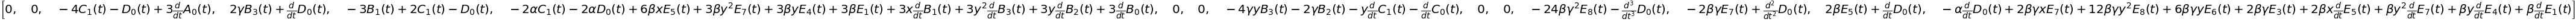

In [42]:
eqs2 = []
for w in LRT1.GB():
    eqs2.append(sum(T1[m.position()].diff(*((v, d) for v, d in zip(var, m)))*c for m, c in w.poly).expand())
eqs2

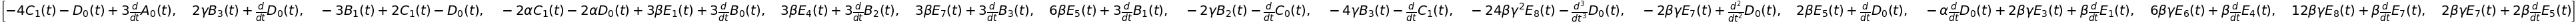

In [43]:
eqs3 = to_eqs(eqs2, [x, y])
eqs3

In [63]:
dct = dict((eval(i.replace("_", "")), f"{{{i}}}") for i in 'A_0, C_0, C_1, B_0, B_1, B_2, B_3, D_0, E_0, E_1, E_2, E_3, E_4, E_5, E_6, E_7, E_8'.split(", "))
for eq in eqs3:
    print(sympy.latex(compact(eq)) + r" = 0, \\")

3 {A_0}_{t} - 4 {C_1} - {D_0} = 0, \\
2 \gamma {B_3} + {D_0}_{t} = 0, \\
- 3 {B_1} + 2 {C_1} - {D_0} = 0, \\
- 2 \alpha {C_1} - 2 \alpha {D_0} + 3 \beta {E_1} + 3 {B_0}_{t} = 0, \\
3 \beta {E_4} + 3 {B_2}_{t} = 0, \\
3 \beta {E_7} + 3 {B_3}_{t} = 0, \\
6 \beta {E_5} + 3 {B_1}_{t} = 0, \\
- 2 \gamma {B_2} - {C_0}_{t} = 0, \\
- 4 \gamma {B_3} - {C_1}_{t} = 0, \\
- 24 \beta \gamma^{2} {E_8} - {D_0}_{ttt} = 0, \\
- 2 \beta \gamma {E_7} + {D_0}_{tt} = 0, \\
2 \beta {E_5} + {D_0}_{t} = 0, \\
- \alpha {D_0}_{t} + 2 \beta \gamma {E_3} + \beta {E_1}_{t} = 0, \\
6 \beta \gamma {E_6} + \beta {E_4}_{t} = 0, \\
12 \beta \gamma {E_8} + \beta {E_7}_{t} = 0, \\
2 \beta \gamma {E_7} + 2 \beta {E_5}_{t} = 0, \\


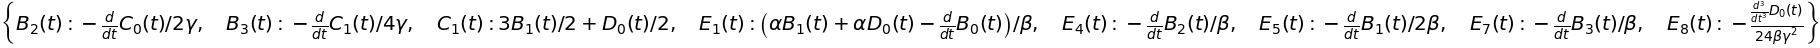

In [46]:
s = sympy.solve([eqs3[2], eqs3[3], eqs3[4], eqs3[5], eqs3[6],\
    eqs3[7], eqs3[8], eqs3[9]], [C1, E1, E4, E7, E5, B2, B3, E8, E3])
s

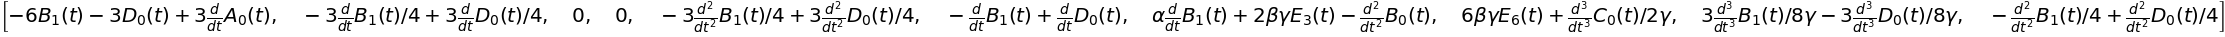

In [48]:
eqs4 = [eq.subs(s).doit().subs(s).doit().expand() for eq in eqs3 if eq.subs(s).doit().expand()]
eqs4

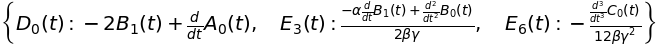

In [49]:
s1 = sympy.solve([eqs4[0], eqs4[-4], eqs4[-3]], [D0, E3, E6])
s1

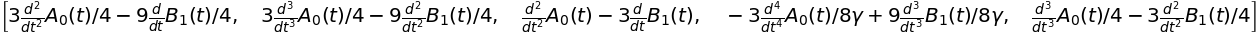

In [50]:
eqs5 = [eq.subs(s1).doit().subs(s1).doit().expand() for eq in eqs4 if eq.subs(s1).doit().expand()]
eqs5

In [51]:
c = sympy.Symbol("c")
s2 = {B1: A0.diff(t)/3 + c}
eqs6 = [eq.subs(s2).doit().subs(s2).doit().expand() for eq in eqs5 if eq.subs(s2).doit().expand()]
eqs6

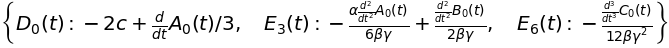

In [52]:
for k, v in s1.items():
    s1[k] = v.subs(s2).doit().subs(s2).doit().expand()
s1

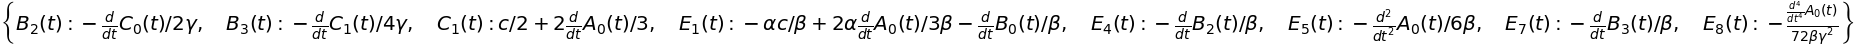

In [53]:
for k, v in s.items():
    s[k] = v.subs(s2).doit().subs(s2).doit().subs(s1).doit().subs(s1).doit().expand()
s

In [66]:
for a, b in s2.items():
    print(fr"\displaystyle {sympy.latex(compact(a))} = {sympy.latex(compact(b))}, \\")
for a, b in s1.items():
    print(fr"\displaystyle {sympy.latex(compact(a))} = {sympy.latex(compact(b))}, \\")
for a, b in s.items():
    print(fr"\displaystyle {sympy.latex(compact(a))} = {sympy.latex(compact(b))}, \\")

\displaystyle {B_1} = c + \frac{{A_0}_{t}}{3}, \\
\displaystyle {D_0} = - 2 c + \frac{{A_0}_{t}}{3}, \\
\displaystyle {E_3} = - \frac{\alpha {A_0}_{tt}}{6 \beta \gamma} + \frac{{B_0}_{tt}}{2 \beta \gamma}, \\
\displaystyle {E_6} = - \frac{{C_0}_{ttt}}{12 \beta \gamma^{2}}, \\
\displaystyle {E_8} = - \frac{{A_0}_{tttt}}{72 \beta \gamma^{2}}, \\
\displaystyle {B_3} = - \frac{{C_1}_{t}}{4 \gamma}, \\
\displaystyle {B_2} = - \frac{{C_0}_{t}}{2 \gamma}, \\
\displaystyle {E_5} = - \frac{{A_0}_{tt}}{6 \beta}, \\
\displaystyle {E_7} = - \frac{{B_3}_{t}}{\beta}, \\
\displaystyle {E_4} = - \frac{{B_2}_{t}}{\beta}, \\
\displaystyle {E_1} = - \frac{\alpha c}{\beta} + \frac{2 \alpha {A_0}_{t}}{3 \beta} - \frac{{B_0}_{t}}{\beta}, \\
\displaystyle {C_1} = \frac{c}{2} + \frac{2 {A_0}_{t}}{3}, \\


In [67]:
T2 = ut*T1[0] + ux*T1[1] + uy*T1[2] + u*T1[3] + T1[4]
T2

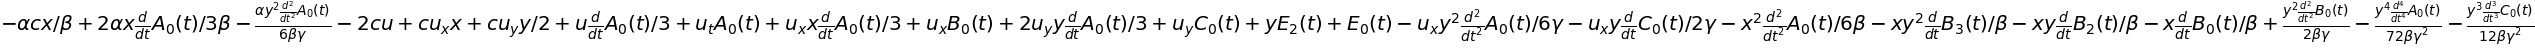

In [75]:
T3 = T2.subs(s).subs(s1).subs(s2).doit().expand()
T3

In [76]:
at = T3.atoms(sympy.Function)
at

\displaystyle u_{y} {C_0} - \frac{u_{x} y {C_0}_{t}}{2 \gamma} - \frac{y^{3} {C_0}_{ttt}}{12 \beta \gamma^{2}}, \\
\displaystyle \frac{2 \alpha x {A_0}_{t}}{3 \beta} - \frac{\alpha y^{2} {A_0}_{tt}}{6 \beta \gamma} + \frac{u {A_0}_{t}}{3} + u_{t} {A_0} + \frac{u_{x} x {A_0}_{t}}{3} + \frac{2 u_{y} y {A_0}_{t}}{3} - \frac{u_{x} y^{2} {A_0}_{tt}}{6 \gamma} - \frac{x^{2} {A_0}_{tt}}{6 \beta} - \frac{y^{4} {A_0}_{tttt}}{72 \beta \gamma^{2}}, \\
\displaystyle u_{x} {B_0} - \frac{x {B_0}_{t}}{\beta} + \frac{y^{2} {B_0}_{tt}}{2 \beta \gamma}, \\
\displaystyle - \frac{x y {B_2}_{t}}{\beta}, \\
\displaystyle {E_0}, \\
\displaystyle y {E_2}, \\
\displaystyle - \frac{x y^{2} {B_3}_{t}}{\beta}, \\


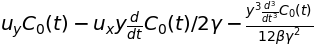

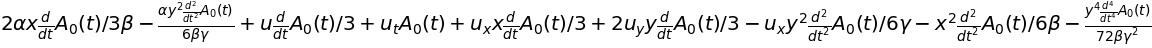

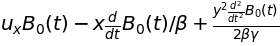

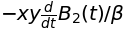

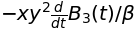

In [78]:
for a in at:
    print(r"\displaystyle " + sympy.latex(compact(sum(i for i in T3.args if a in i.atoms(sympy.Function)))) + r", \\")
    
for a in at:
    display(sum(i for i in T3.args if a in i.atoms(sympy.Function)))

In [74]:
print(sympy.latex(T3.coeff(c)))
T3.coeff(c)

- \frac{\alpha x}{\beta} - 2 u + \frac{u_{y} y}{2}


In [ ]:
Image('Мамонтов1.png')

In [ ]:
Image('Мамонтов2.png')